In [1]:
import sys
sys.path.append("../../..")

from smc.prior import CellPrior
from smc.images import ImageAttributes

import torch
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)
from torchvision.transforms.v2.functional import gaussian_blur

import matplotlib.pyplot as plt
import seaborn as sns

/home/twhit/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Load BBBC039 images

In [2]:
images_bbbc039 = torch.load('../../../data/BBBC039/images.pt').to(device)
counts_bbbc039 = torch.load('../../../data/BBBC039/true_counts.pt').to(device)

Count: 102


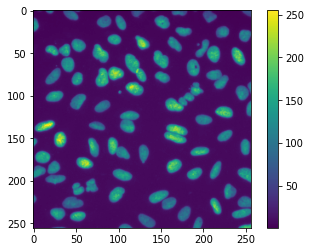

In [3]:
torch.manual_seed(1)

fontsize = 16
cmap = "cividis"

index_bbbc039 = torch.randint(0, images_bbbc039.shape[0], size = (1,)).item()

print(f'Count: {counts_bbbc039[index_bbbc039].int().item()}')
_ = plt.imshow(images_bbbc039[index_bbbc039].cpu())
_ = plt.colorbar()

### Generate synthetic images

Count: 102


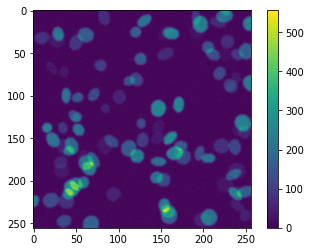

In [4]:
torch.manual_seed(0)

num_images = 50
img_dim = 256 # Needs to be square
img_height = img_dim
img_width = img_dim
max_objects = counts_bbbc039[index_bbbc039].int().item()
psf_size = 5
psf_stdev = 1
background = 10

prior = CellPrior(max_objects, img_height, img_width, min_fluor = background)
image_attributes = ImageAttributes(img_height, img_width, max_objects, psf_size, psf_stdev, background)

# The axes_angles flag is not yet implemented in smc/images.py,
# so we manually generate images with this flag set to true
counts, fluors, locs, axes, angles = prior.sample(num_catalogs = num_images, axes_angles = True)
cell_intensities = fluors.view(num_images, 1, 1, max_objects) * image_attributes.Ellipse(max_objects, locs, axes, angles)
cell_intensities = (cell_intensities).sum(3)
total_intensities = gaussian_blur(cell_intensities, kernel_size = psf_size, sigma = psf_stdev) + background
images = torch.distributions.Poisson(total_intensities).sample()

index_synthetic = torch.where(counts == counts_bbbc039[index_bbbc039].int().item())[0].item()

print(f'Count: {counts[index_synthetic]}')
_ = plt.imshow(images[index_synthetic].cpu())
_ = plt.colorbar()

### Figure 1: Our generative model vs. BBBC039

In [5]:
img_bbbc039 = images_bbbc039[index_bbbc039].cpu()
img_bbbc039_cropped = img_bbbc039[32:64,32:64].cpu()
img_synthetic = images[index_synthetic].cpu()
img_synthetic_cropped = img_synthetic[128:160,32:64].cpu()

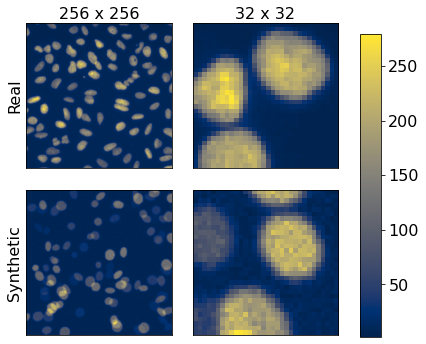

In [6]:
fontsize = 16
cmap = 'cividis'

fig1, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (6,6))
fig1.tight_layout(h_pad = -0.5, w_pad = -0.5)
f = ax[0,0].imshow(img_bbbc039, cmap = cmap)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_xlabel('256 x 256', fontsize = fontsize)
ax[0,0].xaxis.set_label_position("top")
ax[0,0].set_ylabel('Real', fontsize = fontsize)

f = ax[0,1].imshow(img_bbbc039_cropped, cmap = cmap)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_xlabel('32 x 32', fontsize = fontsize)
ax[0,1].xaxis.set_label_position("top")

f = ax[1,0].imshow(img_synthetic, cmap = cmap)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].set_ylabel('Synthetic', fontsize = fontsize)

f = ax[1,1].imshow(img_synthetic_cropped, cmap = cmap)
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])

fig1.subplots_adjust(right = 0.8, hspace = -0.25)
cbar_ax = fig1.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig1.colorbar(f, cax=cbar_ax)
cbar.ax.tick_params(labelsize = fontsize)

fig1.savefig('../results/figures/figure1.png', dpi=500)